In [191]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.contrib.gp as gp
from pyro.contrib.gp.kernels import RBF, WhiteNoise, Linear, Constant, Periodic
from pyro.distributions import LogNormal, HalfNormal
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import TraceMeanField_ELBO


In [353]:
def set_seed(seed):
    """
    Sets the seed for reproducibility in random number generation.

    Parameters:
        seed (int): The seed value to set.
    """
    import numpy as np
    import random
    import torch

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

In [46]:
def g(x):
    # defined on the domain x in [0,1]
    assert 0 <= x <= 1
    return -(np.sin(6*np.pi*x))**2 + 6*x**2 - 5*x**4 + 3/2

In [47]:
l=30

In [327]:
# Generating x values for train & test
X_grid = np.array([(i-1)/(l-1) for i in range(1,l+1)])

# Generating y values for train & test
mu, var = 0, 0.01
eps_grid = np.random.normal(loc = mu,  scale = np.sqrt(var), size = l)
y_grid = np.array([g(xi)+eps for xi, eps in zip(x_grid, eps_grid)])

In [337]:
all_indices = np.arange(30)
train_indices = np.sort(np.random.choice(all_indices, size=20, replace=False))
test_indices = np.setdiff1d(all_indices, train_indices)

# Splitting into train and test
X_train = torch.from_numpy(X_grid[train_indices]).to(torch.float32).reshape(-1,1) #[datapoints, features]
y_train = torch.from_numpy(y_grid[train_indices]).to(torch.float32) #[datapoints]

X_test = torch.from_numpy(X_grid[test_indices]).to(torch.float32).reshape(-1,1) #[datapoints, features] 
y_test = torch.from_numpy(y_grid[test_indices]).to(torch.float32 #datapoints]


In [339]:
# Create a custom GP model class to handle explicit priors
class CustomGPR(GPRegression):
    def model(self):
        # Explicit priors for Linear kernel
        linear_var = pyro.sample("linear_variance", 
            dist.LogNormal(torch.tensor(0.0), torch.tensor(1.0)))

        # Explicit prior for Constant kernel (intercept)
        const_var = pyro.sample("constant_variance",
            dist.LogNormal(torch.tensor(0.0), torch.tensor(1.0)))
        
        # Explicit priors for Periodic kernel
        periodic_var = pyro.sample("periodic_variance", 
            dist.LogNormal(torch.tensor(0.0), torch.tensor(1.0)))
        period = pyro.sample("periodic_period", 
            dist.LogNormal(torch.tensor(-1.6), torch.tensor(0.5)))  # centers around 0.2
        lengthscale = pyro.sample("periodic_lengthscale", 
            dist.LogNormal(torch.tensor(0.0), torch.tensor(1.0)))
        
        # Update kernel parameters
        self.kernel.k1.variance = linear_var
        self.kernel.k2.variance = constant_var
        self.kernel.k3.variance = periodic_var
        self.kernel.k3.period = period
        self.kernel.k3.lengthscale = lengthscale
        
        # Call parent model
        return super().model()

# Setup kernels, None here represents we dont set the parameters to any value as we want to sample from from prior defiend in the model itself
k1 = Linear(input_dim=1,variance=None)
k2 = Constant(input_dim=1, variance=None)  # Constant/intercept term
k3 = Periodic(input_dim=1, period=None, variance=None, lengthscale=None)
kernel = Sum(Sum(k1, k2), k3)

# Create model with custom priors which we will use to regularize in our search for optimal hyperparameters
gp = CustomGPR(X_train, y_train, kernel)

In [420]:
# Function to sample parameters from priors and create a kernel
def sample_kernel_from_prior():
    # Sample parameters from priors
    linear_scale = pyro.sample("linear_scale", 
        dist.LogNormal(torch.tensor(0.0), torch.tensor(1.0)))
    offset_scale = pyro.sample("offset_scale",
        dist.LogNormal(torch.tensor(0.0), torch.tensor(1.0)))
    periodic_amplitude = pyro.sample("periodic_amplitude", 
        dist.LogNormal(torch.tensor(0.0), torch.tensor(1.0)))
    period = pyro.sample("period", 
        dist.LogNormal(torch.tensor(-1.6), torch.tensor(0.5)))
    lengthscale = pyro.sample("lengthscale", 
        dist.LogNormal(torch.tensor(0.0), torch.tensor(1.0)))
    
    # Create kernels with sampled parameters
    k1 = Linear(1, variance=linear_scale)
    k2 = Constant(1, variance=offset_scale)
    k3 = Periodic(input_dim=1, period=period, variance=periodic_amplitude, lengthscale=lengthscale)
    return Sum(Sum(k1, k2), k3)

failed: Added jitter gp: 1
failed: Added jitter gp: 2
failed: Added jitter gp: 3
failed: Added jitter gp: 4
failed: Added jitter gp: 5
failed: Added jitter gp: 6
failed: Added jitter gp: 7
failed: Added jitter gp: 8
failed: Added jitter gp: 9
failed: Added jitter gp: 10


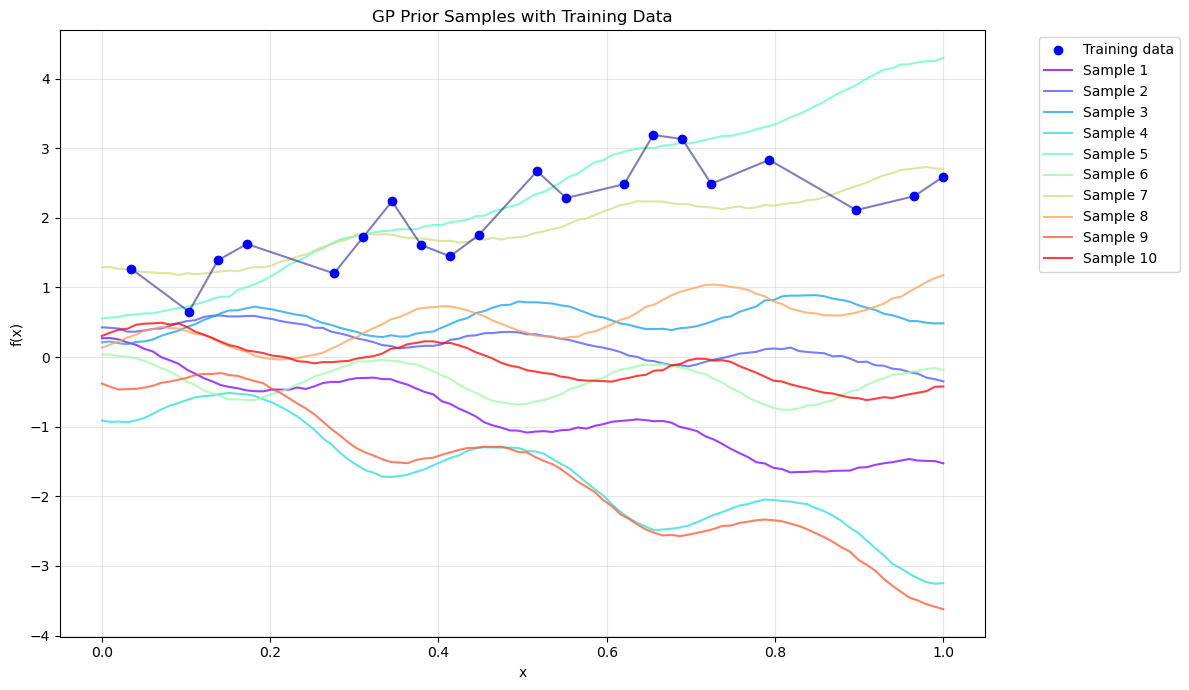

In [429]:
def plot_gp_samples(x_train, y_train, num_samples=10, jitter_init=1e-6):
    x_visual = torch.linspace(0, 1, 100)
    plt.figure(figsize=(12, 7))
    
    # Plot training data first
    plt.scatter(x_train, y_train, color='blue', zorder=5, label='Training data')
    plt.plot(x_train, y_train, color='navy', alpha=0.5, zorder=4)
    
    # Sample and plot functions
    colors = plt.cm.rainbow(np.linspace(0, 1, num_samples))
    for i, color in enumerate(colors):
        kernel = sample_kernel_from_prior()
        K = kernel(x_visual, x_visual)
        K.diagonal().add_(jitter_init)
        
        try:
            f = dist.MultivariateNormal(torch.zeros(len(x_visual)), K).sample()
            plt.plot(x_visual.numpy(), f.numpy(), alpha=0.75, color=color, 
                    label=f"Sample {i+1}", zorder=3)
            print("works")
        except ValueError:
            print("failed: Added jitter gp:",i+1)
            K.diagonal().add_(1e-4)  # Increase jitter if needed
            f = dist.MultivariateNormal(torch.zeros(len(x_visual)), K).sample()
            plt.plot(x_visual.numpy(), f.numpy(), alpha=0.75, color=color, 
                    label=f"Sample {i+1}", zorder=3)
    
    plt.title('GP Prior Samples with Training Data', fontsize=12)
    plt.xlabel('x', fontsize=10)
    plt.ylabel('f(x)', fontsize=10)
    plt.grid(True, alpha=0.3, zorder=1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    return plt.gcf()

# Usage
fig = plot_gp_samples(X_train, y_train)
plt.show()

In [487]:
kernel = sample_kernel_from_prior()
linear_scale = kernel.kern0.kern0.variance.item()
offset_scale = kernel.kern0.kern1.variance.item()
periodic_amplitude = kernel.kern1.variance.item()
period = kernel.kern1.period.item()
lengthscale = kernel.kern1.lengthscale.item()
print("\nSample parameter values:")
print(f"Linear scale: {linear_scale:.3f}")
print(f"Offset scale: {offset_scale:.3f}")
print(f"Periodic amplitude: {periodic_amplitude:.3f}")
print(f"Period: {period:.3f}")
print(f"Lengthscale: {lengthscale:.3f}")



def gp_function_sampled(x, linear_scale, offset_scale, periodic_amplitude, period, lengthscale):
    # Linear component
    linear_part = linear_scale * x  # σ₁²x
    
    # Constant component
    constant_part = offset_scale    # σ₂²
    
    # Periodic component with lengthscale
    periodic_part = periodic_amplitude * np.exp(-2 * np.sin(np.pi * x/period)**2 / lengthscale**2)
    
    return linear_part + constant_part + periodic_part


Sample parameter values:
Linear scale: 2.105
Offset scale: 0.386
Periodic amplitude: 0.724
Period: 0.188
Lengthscale: 1.301


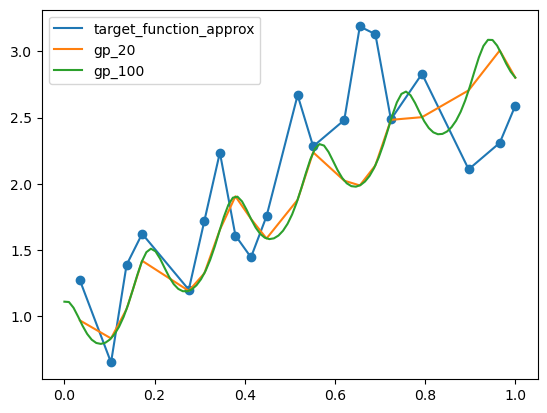

In [511]:
y_visualize_gp_100 = gp_function_sampled(torch.linspace(0,1,100),
                                         linear_scale=linear_scale, 
                                         offset_scale=offset_scale, 
                                         periodic_amplitude=periodic_amplitude, 
                                         period=period, 
                                         lengthscale=lengthscale)
y_visualize_gp_20 = gp_function_sampled(X_train, 
                                        linear_scale=linear_scale, 
                                        offset_scale=offset_scale,
                                        periodic_amplitude=periodic_amplitude, 
                                        period=period, 
                                        lengthscale=lengthscale)
plt.scatter(X_train, y_train)
plt.plot(X_train, y_train, label="target_function_approx")
plt.plot(X_train,y_visualize_gp_20, label="gp_20")
plt.plot(torch.linspace(0,1,100), y_visualize_gp_100, label="gp_100")
plt.legend()
plt.show()